In [1]:
library(SBC);
library(cmdstanr);
library(tidyverse);
options(mc.cores = parallel::detectCores());
library(future);
plan(multisession);

options(SBC.min_chunk_size = 5);

cache_dir <- "./SBC_cache"
if(!dir.exists(cache_dir)) {
  dir.create(cache_dir)
}

model_BT_1 <- cmdstanr::cmdstan_model("../models/BT_model_1.stan")
model_BT_2 <- cmdstanr::cmdstan_model("../models/BT_model_2.stan")

This is cmdstanr version 0.7.1

- CmdStanR documentation and vignettes: mc-stan.org/cmdstanr

- CmdStan path: /Users/igor.michels/.cmdstan/cmdstan-2.34.1

- CmdStan version: 2.34.1

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message in readLines(stan_file):
“linha final incompleta encontrada em '../models/BT_model.stan'”
Warning message in readLines(stan_file):
“linha final incompleta encontrada em '../models/BT_model_2.stan'”


In [2]:
data_generator_single_BT_1 <- function(n_clubs){
    n_seasons <- 1
    clubs <- sprintf("Club %02d", 1:n_clubs)
    clubs <- 1:n_clubs
    force <- rnorm(length(clubs))
    df <- data.frame(Club = clubs, Force = force)
    data <- merge(df, df, by = NULL) %>% filter(Club.x != Club.y)
    data$prob.home <- exp(data$Force.x) / (exp(data$Force.x) + exp(data$Force.y))
    data$home.wins <- 0

    for (i in 1:n_seasons) {
        data$random <- runif(n_clubs * (n_clubs - 1))
        data$home.wins <- data$home.wins + (data$random <  data$prob.home) * 1
    }

    data$away.wins <- n_seasons - data$home.wins
    data <- subset(data, select = -random)
    data <- subset(data, select = -prob.home)
    names(data) <- c("home_name", "home_force", "away_name", "away_force",
                     "home_wins", "away_wins")

    list(
        variables = list(
            habilidade = force
        ),
        generated = list(
            num_jogos = nrow(data),
            num_equipes = n_clubs,
            equipe1 = data$home_name,
            equipe2 = data$away_name,
            vitoria_equipe1 = data$home_wins
        )
    )
}

In [3]:
data_generator_single_BT_2 <- function(n_clubs){
    n_seasons <- 1
    clubs <- sprintf("Club %02d", 1:n_clubs)
    clubs <- 1:n_clubs
    force <- rnorm(length(clubs))
    home_force <- rnorm(1)
    df <- data.frame(Club = clubs, Force = force)
    data <- merge(df, df, by = NULL) %>% filter(Club.x != Club.y)
    data$prob.home <- exp(data$Force.x + home_force) / (exp(data$Force.x) + exp(data$Force.y))
    data$home.wins <- 0

    for (i in 1:n_seasons) {
        data$random <- runif(n_clubs * (n_clubs - 1))
        data$home.wins <- data$home.wins + (data$random <  data$prob.home) * 1
    }

    data$away.wins <- n_seasons - data$home.wins
    data <- subset(data, select = -random)
    data <- subset(data, select = -prob.home)
    names(data) <- c("home_name", "home_force", "away_name", "away_force",
                     "home_wins", "away_wins")

    list(
        variables = list(
            habilidade = force,
            home_force = home_force
        ),
        generated = list(
            num_jogos = nrow(data),
            num_equipes = n_clubs,
            equipe1 = data$home_name,
            equipe2 = data$away_name,
            vitoria_equipe1 = data$home_wins
        )
    )
}

In [4]:
n_sims <- 250
data_generator_BT_1 <- SBC_generator_function(data_generator_single_BT_1, n_clubs = 20)
dataset_BT_1 <- generate_datasets(data_generator_BT_1, n_sims)
backend_BT_1 <- SBC_backend_cmdstan_sample(model_BT_1, iter_warmup = 2000,
                                           iter_sampling = 4000, chains = 4)

results_BT_1 <- compute_SBC(dataset_BT_1, backend_BT_1,
                            cache_mode = "results",
                            cache_location = file.path(cache_dir, "results_BT_1"))

In [5]:
n_sims <- 250
data_generator_BT_2 <- SBC_generator_function(data_generator_single_BT_2, n_clubs = 20)
dataset_BT_2 <- generate_datasets(data_generator_BT_2, n_sims)
backend_BT_2 <- SBC_backend_cmdstan_sample(model_BT_2, iter_warmup = 2000,
                                           iter_sampling = 4000, chains = 4)

results_BT_2 <- compute_SBC(dataset_BT_2, backend_BT_2,
                            cache_mode = "results",
                            cache_location = file.path(cache_dir, "results_BT_2"))

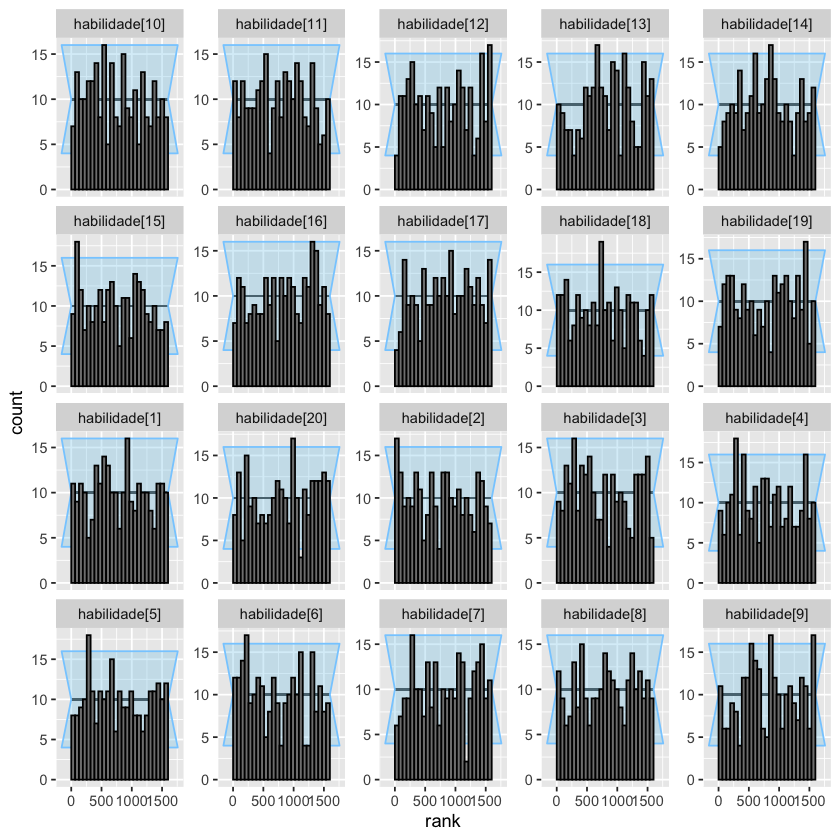

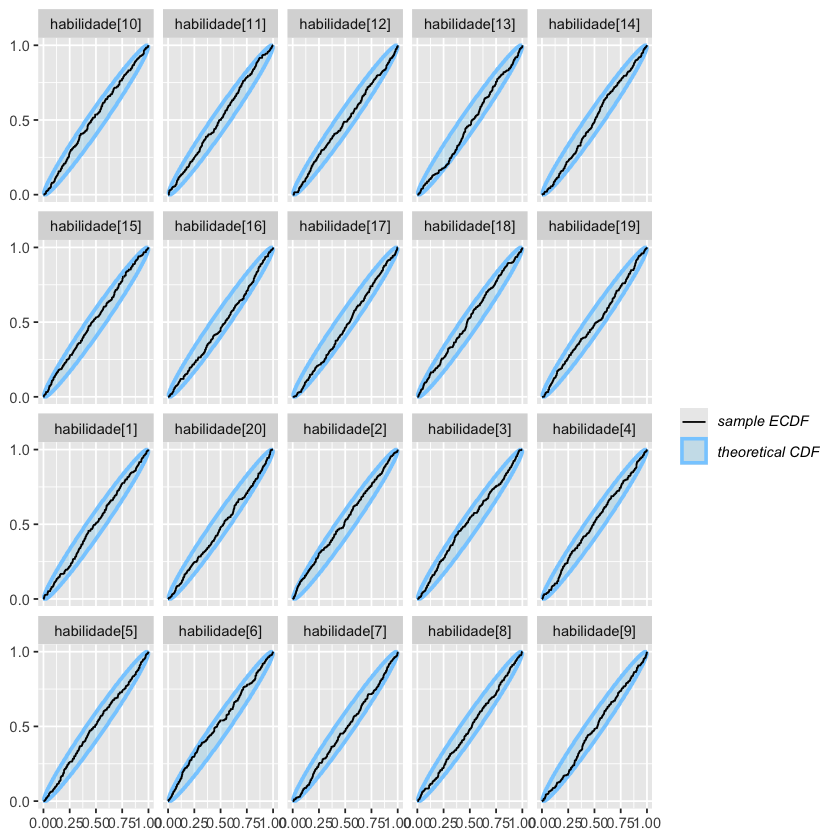

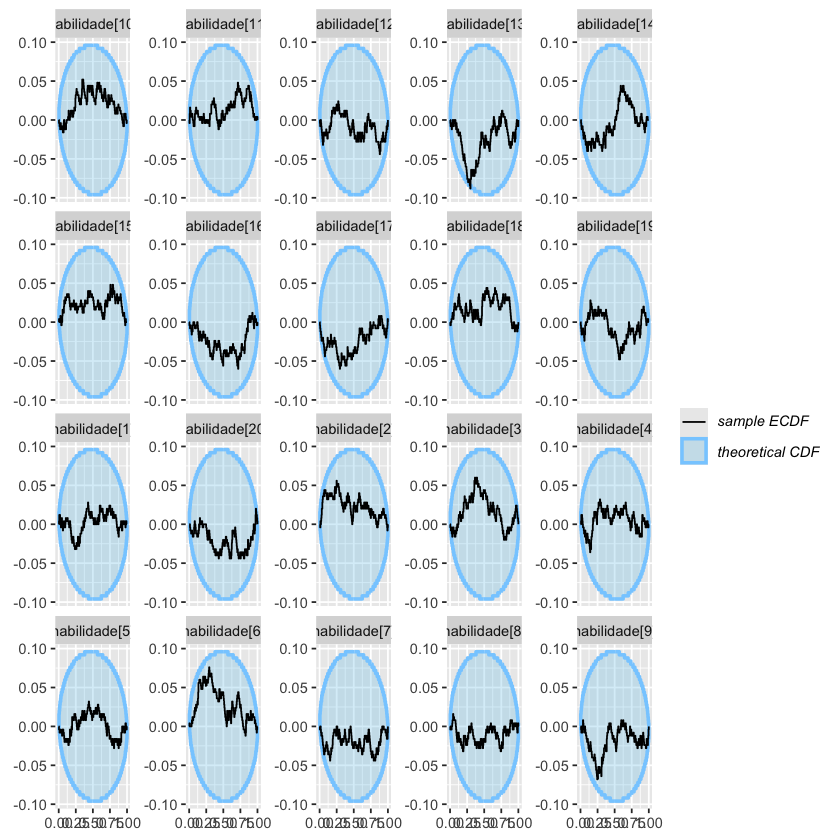

In [6]:
plot_rank_hist(results_BT_1)
plot_ecdf(results_BT_1)
plot_ecdf_diff(results_BT_1)

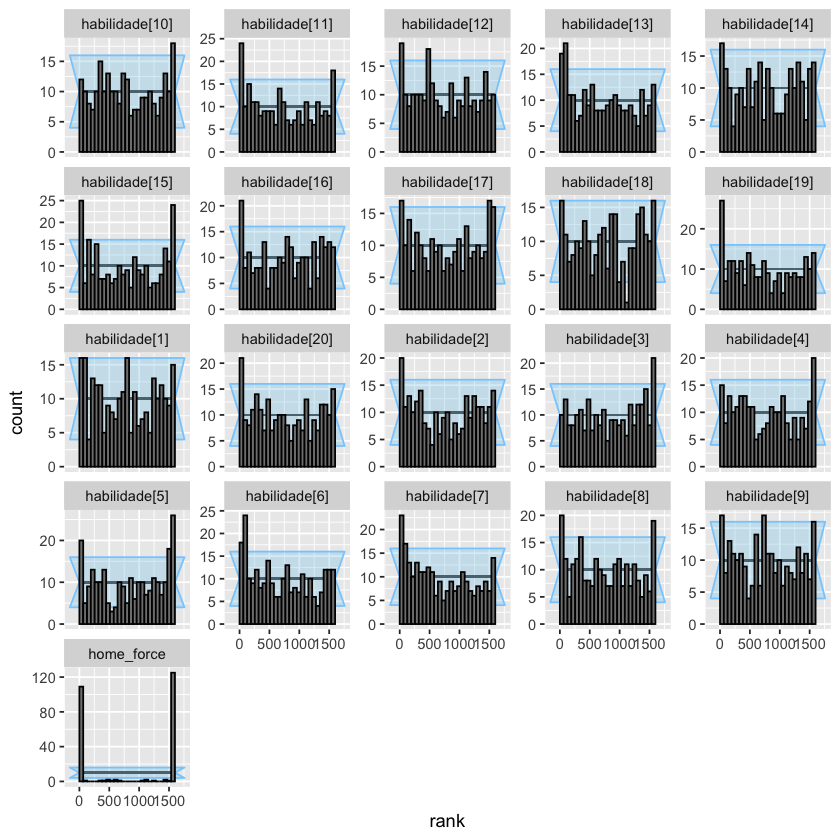

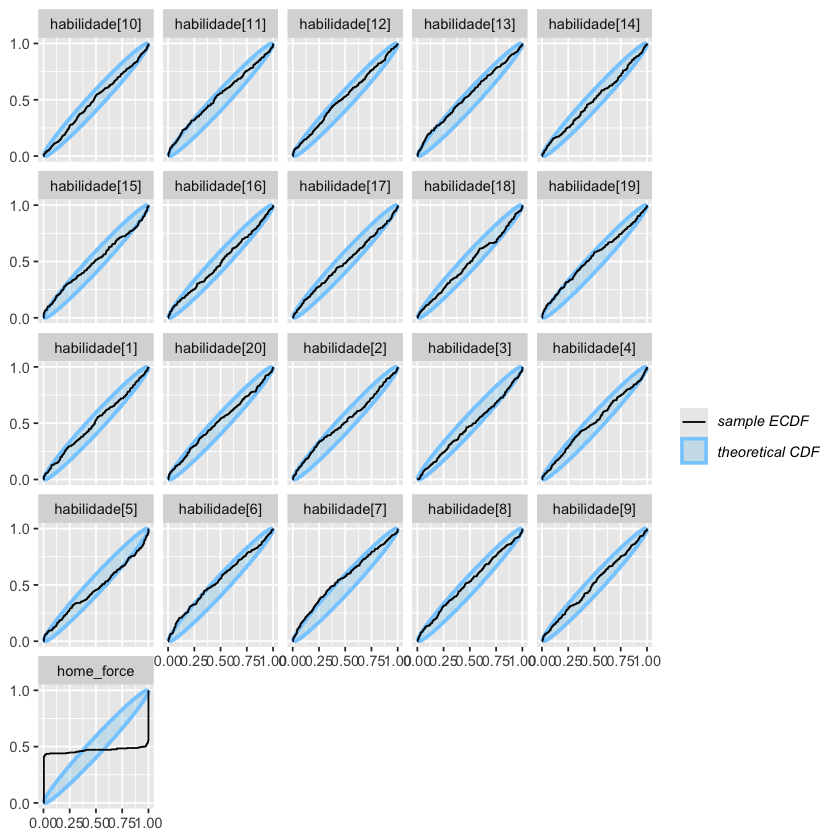

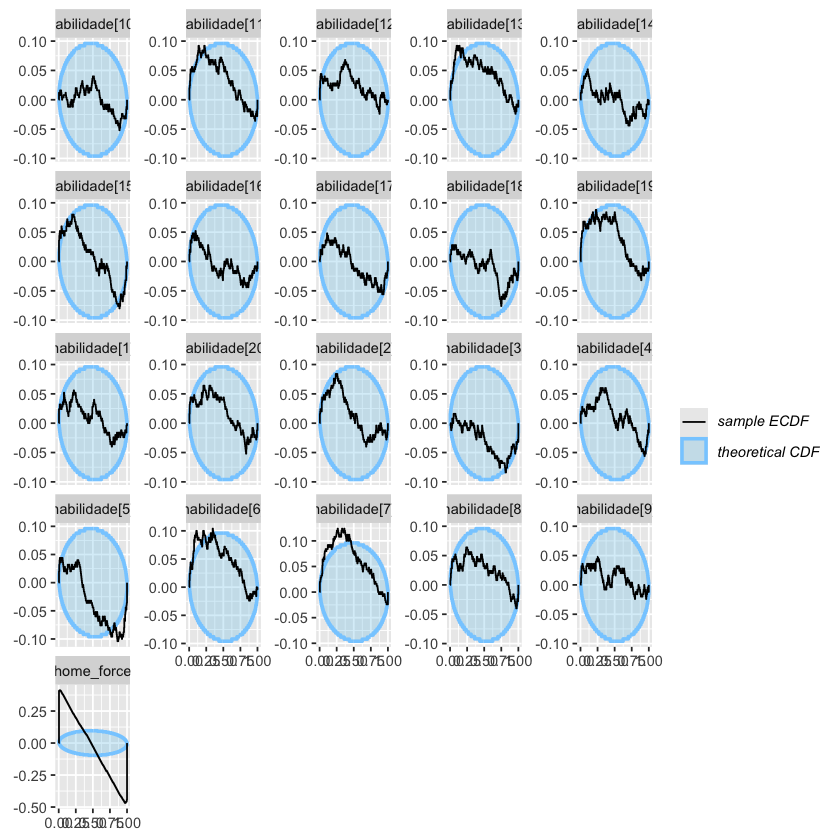

In [7]:
plot_rank_hist(results_BT_2)
plot_ecdf(results_BT_2)
plot_ecdf_diff(results_BT_2)